In [1]:
import numpy as np

INF = float('inf')

def floyd_warshall(graph):
    num_vertices = len(graph)
    dist = np.full((num_vertices, num_vertices), INF)

    # Initialize distances based on graph
    for i in range(num_vertices):
        for j in range(num_vertices):
            if i == j:
                dist[i][j] = 0
            elif graph[i][j] != 0:
                dist[i][j] = graph[i][j]

    # Floyd-Warshall Algorithm
    for k in range(num_vertices):
        for i in range(num_vertices):
            for j in range(num_vertices):
                dist[i][j] = min(dist[i][j], dist[i][k] + dist[k][j])

    return dist


In [2]:
N = 500
adj = np.eye(N)* 0
for i in range(1, N-1):
    adj[i, i-1] = adj[i, i+1] = 1

adj[0][1] = adj[0][N-1] = adj[N-1][0] = adj[N-1][N-2] = 1
shortest_paths = floyd_warshall(adj)
print(shortest_paths)

[[0. 1. 2. ... 3. 2. 1.]
 [1. 0. 1. ... 4. 3. 2.]
 [2. 1. 0. ... 5. 4. 3.]
 ...
 [3. 4. 5. ... 0. 1. 2.]
 [2. 3. 4. ... 1. 0. 1.]
 [1. 2. 3. ... 2. 1. 0.]]


In [3]:
shortestpathdict = {}
n = len(shortest_paths)
for i in range(n):
    for j in range(i + 1, n):
        if shortest_paths[i][j] in shortestpathdict:
            shortestpathdict[shortest_paths[i][j]].append((i, j))
        else:
            shortestpathdict[shortest_paths[i][j]] = [(i, j)]


In [4]:
import networkx as nx
G = nx.from_numpy_array(adj)

E = list(G.edges)

In [5]:
import numpy as np

class Counter(dict):
    largest_non_zero = 0
    def increment(self, item, delta = 1):
        new_val = delta + self.pop(item, 0)
        if new_val > 0: 
            self[item] = new_val
            if (item != 0) and (new_val > self.largest_non_zero):
                self.largest_non_zero = new_val

def y(x):
    return 2**x


def jaccard_index(a, b):
    intersection = (a & b).bit_count()
    union = (a | b).bit_count()
    return intersection / union if union else 0

def find_tranformation_matrix(b, E, N, Tmax, stopping_crit = 0):

    M = np.shape(E)[0]
    ## find the number of events that occur in the interval from T = 0 to T = Tmax
    n = np.random.poisson(lam = Tmax*(N+b*M))

    ## find times for all events
    times = np.sort(np.random.uniform(0, Tmax, n))
    R = np.zeros(n, dtype = int)

    ## initialize the transformation matrix X    
    X = [2**i for i in range(N)][::-1]
    ## initialize the Similarity matrix J
    J = np.eye(N)

    counts = Counter()
    for element in X:
        counts.increment(element, 1)

    # run simulation
    for t in range(n):
        
        if np.random.random() < N/(N + b*M):
            ## recovery event: 
            i = np.random.randint(N)
            # print(f"Recovery event of {i} which is {X[i]}")

            if X[i] != 0:
                
                counts.increment(X[i], -1)

                X[i] = 0

                counts.increment(0, 1)

                ## update the similarity matrix (find max over all time)
                for a in range(N):
                    new_val = jaccard_index(X[i], X[a])
                    if new_val > J[a, i]:
                        J[i, a] = J[a, i] = new_val
        
        ## infection event:
        else:

            i,j = E[np.random.randint(M)]
            # print(f"spreading event between {i} which is {X[i]} and {j} which is {X[j]}")
            if (X[i] != 0 or X[j] != 0) and X[i] != X[j]:
                    
                new = X[i] | X[j]
                counts.increment(X[i], -1)
                counts.increment(X[j], -1)
                counts.increment(new, 2)
                X[i] = X[j] = new

                ## update the similarity matrix:
                for a in range(N):
                    new_val = jaccard_index(X[i], X[a]) ## X[i] = X[j] after spreading event
                    if new_val > J[a, i]:
                        J[a, i] = J[i, a] = new_val
                    if new_val > J[a, j]:
                        J[a, j] = J[j, a] = new_val
                
        R[t] = non_zero_distinct_rows = len(counts) - (0 in counts)
        ## storing s1star for the largest non-zero count
        spatial = counts.largest_non_zero
        
        ## break the simulation because the pseudo mixing time has been found (the number of distinct rows and thus distinct columns is 2 or extinction, depending)

        if non_zero_distinct_rows == stopping_crit:
            times = times[:t+1]
            R = R[:t+1]
            break

    return times, R, spatial, J

In [6]:
bs = np.linspace(0, 5, 15)
J_list = []
Tmax = 100
for b in bs:
    Js = []
    for i in range(50):
        times, R, spatial, J = find_tranformation_matrix(b, E, N, Tmax, 0)
        Js.append(J)
    average = np.mean(Js, axis=0)
    J_list.append(average)

print(J_list)

[array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]]), array([[1.        , 0.48      , 0.12333333, ..., 0.01      , 0.15333333,
        0.48      ],
       [0.48      , 1.        , 0.44      , ..., 0.02      , 0.07      ,
        0.2       ],
       [0.12333333, 0.44      , 1.        , ..., 0.02      , 0.04      ,
        0.06333333],
       ...,
       [0.01      , 0.02      , 0.02      , ..., 1.        , 0.32      ,
        0.05333333],
       [0.15333333, 0.07      , 0.04      , ..., 0.32      , 1.        ,
        0.44      ],
       [0.48      , 0.2       , 0.06333333, ..., 0.05333333, 0.44      ,
        1.        ]]), array([[1.        , 0.78      , 0.46533333, ..., 0.35704762, 0.59166667,
        0.9       ],
       [0.78      , 1.        , 0.82      , ..., 0.18166667, 0.29933333,
        0.56

In [7]:
J1 = []
J2 = []
J3 = []
J4 = []
J5 = []
J6 = []
J7 = []
J8 = []
J9 = []
J10 = []
J11 = []
J12 = []
J13 = []
J14 = []
J15 = []
ks = []

for k, v in shortestpathdict.items():
    temp = []
    ks.append(k)
    for element in v:
        temp.append(J_list[0][element[0]][element[1]])
    J1.append(np.mean(temp))

for k, v in shortestpathdict.items():
    temp = []
    for element in v:
        temp.append(J_list[1][element[0]][element[1]])
    J2.append(np.mean(temp))

for k, v in shortestpathdict.items():
    temp = []
    for element in v:
        temp.append(J_list[2][element[0]][element[1]])
    J3.append(np.mean(temp))

for k, v in shortestpathdict.items():
    temp = []
    for element in v:
        temp.append(J_list[3][element[0]][element[1]])
    J4.append(np.mean(temp))

for k, v in shortestpathdict.items():
    temp = []
    for element in v:
        temp.append(J_list[4][element[0]][element[1]])
    J5.append(np.mean(temp))

for k, v in shortestpathdict.items():
    temp = []
    for element in v:
        temp.append(J_list[5][element[0]][element[1]])
    J6.append(np.mean(temp))

for k, v in shortestpathdict.items():
    temp = []
    for element in v:
        temp.append(J_list[6][element[0]][element[1]])
    J7.append(np.mean(temp))

for k, v in shortestpathdict.items():
    temp = []
    for element in v:
        temp.append(J_list[7][element[0]][element[1]])
    J8.append(np.mean(temp))

for k, v in shortestpathdict.items():
    temp = []
    for element in v:
        temp.append(J_list[8][element[0]][element[1]])
    J9.append(np.mean(temp))

for k, v in shortestpathdict.items():
    temp = []
    for element in v:
        temp.append(J_list[9][element[0]][element[1]])
    J10.append(np.mean(temp))


for k, v in shortestpathdict.items():
    temp = []
    for element in v:
        temp.append(J_list[10][element[0]][element[1]])
    J11.append(np.mean(temp))


for k, v in shortestpathdict.items():
    temp = []
    for element in v:
        temp.append(J_list[11][element[0]][element[1]])
    J12.append(np.mean(temp))


for k, v in shortestpathdict.items():
    temp = []
    for element in v:
        temp.append(J_list[12][element[0]][element[1]])
    J13.append(np.mean(temp))


for k, v in shortestpathdict.items():
    temp = []
    for element in v:
        temp.append(J_list[13][element[0]][element[1]])
    J14.append(np.mean(temp))


for k, v in shortestpathdict.items():
    temp = []
    for element in v:
        temp.append(J_list[14][element[0]][element[1]])
    J15.append(np.mean(temp))

In [9]:
print(bs)

[0.         0.35714286 0.71428571 1.07142857 1.42857143 1.78571429
 2.14285714 2.5        2.85714286 3.21428571 3.57142857 3.92857143
 4.28571429 4.64285714 5.        ]


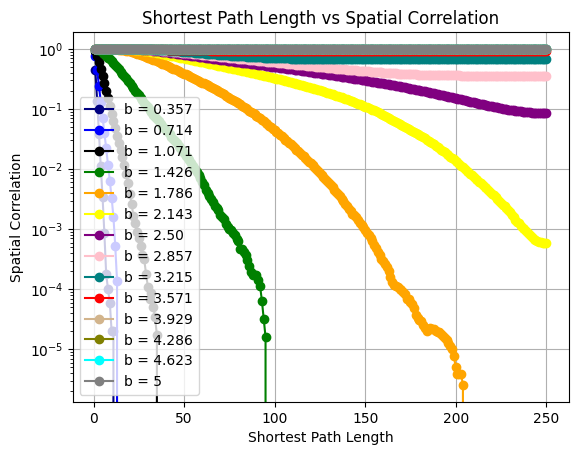

In [11]:
import matplotlib.pyplot as plt
# Plot line joining points
plt.plot(ks, J2, color='navy', linestyle='-', marker='o', label='b = 0.357')
plt.plot(ks, J3, color='blue', linestyle='-', marker='o', label='b = 0.714')
plt.plot(ks, J4, color='black', linestyle='-', marker='o', label='b = 1.071')
plt.plot(ks, J5, color='green', linestyle='-', marker='o', label='b = 1.426')
plt.plot(ks, J6, color='orange', linestyle='-', marker='o', label='b = 1.786')
plt.plot(ks, J7, color='yellow', linestyle='-', marker='o', label='b = 2.143')
plt.plot(ks, J8, color='purple', linestyle='-', marker='o', label='b = 2.50')
plt.plot(ks, J9, color='pink', linestyle='-', marker='o', label='b = 2.857')
plt.plot(ks, J10, color='teal', linestyle='-', marker='o', label='b = 3.215')
plt.plot(ks, J11, color='red', linestyle='-', marker='o', label='b = 3.571')
plt.plot(ks, J12, color='tan', linestyle='-', marker='o', label='b = 3.929')
plt.plot(ks, J13, color='olive', linestyle='-', marker='o', label='b = 4.286')
plt.plot(ks, J14, color='cyan', linestyle='-', marker='o', label='b = 4.623')
plt.plot(ks, J15, color='gray', linestyle='-', marker='o', label='b = 5')


# Add labels and legend
plt.xlabel('Shortest Path Length')
plt.ylabel('Spatial Correlation')
plt.yscale('log')
plt.title('Shortest Path Length vs Spatial Correlation')
plt.legend()

# Show plot
plt.grid(True)
plt.show()

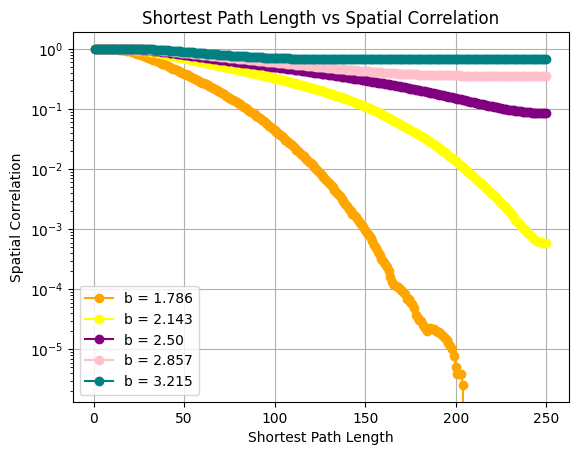

In [23]:
import matplotlib.pyplot as plt
# Plot line joining points
# plt.plot(ks, J2, color='navy', linestyle='-', marker='o', label='b = 0.357')
# plt.plot(ks, J3, color='blue', linestyle='-', marker='o', label='b = 0.714')
# plt.plot(ks, J4, color='black', linestyle='-', marker='o', label='b = 1.071')
# plt.plot(ks, J5, color='green', linestyle='-', marker='o', label='b = 1.426')
plt.plot(ks, J6, color='orange', linestyle='-', marker='o', label='b = 1.786')
plt.plot(ks, J7, color='yellow', linestyle='-', marker='o', label='b = 2.143')
plt.plot(ks, J8, color='purple', linestyle='-', marker='o', label='b = 2.50')
plt.plot(ks, J9, color='pink', linestyle='-', marker='o', label='b = 2.857')
plt.plot(ks, J10, color='teal', linestyle='-', marker='o', label='b = 3.215')
# plt.plot(ks, J11, color='red', linestyle='-', marker='o', label='b = 3.571')
# plt.plot(ks, J12, color='tan', linestyle='-', marker='o', label='b = 3.929')
# plt.plot(ks, J13, color='olive', linestyle='-', marker='o', label='b = 4.286')
# plt.plot(ks, J14, color='cyan', linestyle='-', marker='o', label='b = 4.623')
# plt.plot(ks, J15, color='gray', linestyle='-', marker='o', label='b = 5')


# Add labels and legend
plt.xlabel('Shortest Path Length')
# plt.ylim(0.01, 1)
plt.ylabel('Spatial Correlation')
plt.yscale('log')
# plt.xscale('log')
plt.title('Shortest Path Length vs Spatial Correlation')
plt.legend()

# Show plot
plt.grid(True)
plt.show()

In [27]:
b = 3.125
Tmax = 200
Js = []
for i in range(1):
    times, R, spatial, J = find_tranformation_matrix(b, E, N, Tmax, 1)


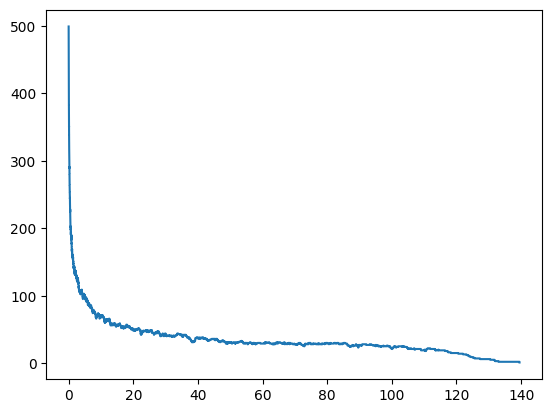

In [28]:
plt.plot(times, R)
plt.show()